In [1]:
'''
Base Model full pipeline
'''

'\nBase Model full pipeline\n'

In [0]:
from __future__ import absolute_import, division, print_function

In [3]:
import tensorflow as tf

tf.enable_eager_execution()
tf.__version__

'1.13.1'

In [4]:
from tensorflow.keras.layers import Bidirectional,CuDNNGRU,CuDNNLSTM,GRU,LSTM,concatenate,Dense,Input,Embedding
from tensorflow.keras.layers import  multiply, Flatten
from tensorflow.keras.layers import Lambda, Masking
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from hyperopt import Trials, STATUS_OK, tpe,  fmin, tpe, hp, STATUS_OK, Trials
import importlib
from keras import backend as K

Using TensorFlow backend.


In [5]:
!pip install h5py

!apt-get install -y libhdf5-dev

!pip install fasttext


Reading package lists... Done
Building dependency tree       
Reading state information... Done
libhdf5-dev is already the newest version (1.10.0-patch1+docs-4).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.
    100% |████████████████████████████████| 81kB 3.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/73/8e/5d/ecb50b90adaab5868ae1d8df180f31e55e85c2f055aaf2fb35
Successfully built fasttext


In [6]:
#Setup between colab and drive and fuse or something!!
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p drive
!google-drive-ocamlfuse drive

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131304 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [7]:
import json
import fasttext
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import tensorflow.keras.layers as layers
from tensorflow.keras.datasets import imdb
from gensim.models import Word2Vec
from gensim.models import FastText
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score,classification_report

W0425 18:32:31.716961 139660457392000 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14
/usr/local/lib/python3.6/dist-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [0]:
import h5py

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

## Download and prepare the MS-COCO dataset

In [0]:
annotation_zip = tf.keras.utils.get_file('captions.zip', 
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'

name_of_zip = 'train2014.zip'
if not os.path.exists(os.path.abspath('.') + '/' + name_of_zip):
  image_zip = tf.keras.utils.get_file(name_of_zip, 
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip)+'/train2014/'
else:
  PATH = os.path.abspath('.')+'/train2014/'

**Utility functions**

---

---

# Prepare the Embeddings using word vector models


In [0]:

params_set = {
    "embed_dim":300,
    "split_ratio":0.33,
    "max_len":200,
    "vocab_size":10000,
    "trainable_param":"False",
    "option":2,
    "workers":3,
    "window":1

}

model_params = {
    "epochs":10,
    "batch_size":1024,
    "loss":"binary_crossentropy",
    "optimizer":"adam",
    "metrics":["accuracy"]

}


def json_to_dict(json_set):
    for k,v in json_set.items():
        if v == "True":
            json_set[k]= True
        elif v == "False":
            json_set[k]=False
        else:
            json_set[k]=v
    return json_set

  
  


def load_data(vocab_size,max_len):
    """
        Loads the keras imdb dataset
        Args:
            vocab_size = {int} the size of the vocabulary
            max_len = {int} the maximum length of input considered for padding
        Returns:
            X_train = tokenized train data
            X_test = tokenized test data
    """
    INDEX_FROM = 3

    (X_train,y_train),(X_test,y_test) = imdb.load_data(num_words = vocab_size,index_from = INDEX_FROM)

    return X_train,X_test,y_train,y_test


def prepare_data_for_word_vectors_imdb(X_train):
    """
        Prepares the input
        Args:
            X_train = tokenized train data
        Returns:
            sentences = {list} sentences containing words as tokens
            word_index = {dict} word and its indexes in whole of imdb corpus
    """
    INDEX_FROM = 3
    word_to_index = imdb.get_word_index()
    word_to_index = {k:(v+INDEX_FROM) for k,v in word_to_index.items()}

    word_to_index["<START>"] =1
    word_to_index["<UNK>"]=2

    index_to_word = {v:k for k,v in word_to_index.items()}

    sentences = []
    for i in range(len(X_train)):
        temp = [index_to_word[ids] for ids in X_train[i]]
        sentences.append(temp)
    """
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    word_indexes = tokenizer.word_index
    """
    return sentences,word_to_index


def prepare_data_for_word_vectors(X):
    sentences_as_words=[]
    word_to_index={}
    count=1
    for sent in X:
        temp = sent.split()
        sentences_as_words.append(temp)
    for sent in sentences_as_words:
        for word in sent:
            if word_to_index.get(word,None) is None:
                word_to_index[word] = count
                count +=1
    index_to_word = {v:k for k,v in word_to_index.items()}
    sentences=[]
    for i in range(len(sentences_as_words)):
        temp = [word_to_index[w] for w in sentences_as_words[i]]
        sentences.append(temp)


    return sentences_as_words,sentences,word_to_index

def data_prep_ELMo(train_x,train_y,test_x,test_y,max_len):

    INDEX_FROM = 3
    word_to_index = imdb.get_word_index()
    word_to_index = {k:(v+INDEX_FROM) for k,v in word_to_index.items()}

    word_to_index["<START>"] =1
    word_to_index["<UNK>"]=2

    index_to_word = {v:k for k,v in word_to_index.items()}

    sentences=[]
    for i in range(len(train_x)):
        temp = [index_to_word[ids] for ids in train_x[i]]
        sentences.append(temp)

    test_sentences=[]
    for i in range(len(test_x)):
        temp = [index_to_word[ids] for ids in test_x[i]]
        test_sentences.append(temp)

    train_text = [' '.join(sentences[i][:max_len]) for i in range(len(sentences))]
    train_text = np.array(train_text, dtype=object)[:, np.newaxis]
    train_label = train_y.tolist()

    test_text = [' '.join(test_sentences[i][:500]) for i in range(len(test_sentences))]
    test_text = np.array(test_text , dtype=object)[:, np.newaxis]
    test_label = test_y.tolist()

    return train_text,train_label,test_text,test_label


def building_word_vector_model(option,sentences,embed_dim,workers,window,y_train):
    """
        Builds the word vector
        Args:
            type = {bool} 0 for Word2vec. 1 for gensim Fastext. 2 for Fasttext 2018.
            sentences = {list} list of tokenized words
            embed_dim = {int} embedding dimension of the word vectors
            workers = {int} no. of worker threads to train the model (faster training with multicore machines)
            window = {int} max distance between current and predicted word
            y_train = y_train
        Returns:
            model = Word2vec/Gensim fastText/ Fastext_2018 model trained on the training corpus
    """
    if option == 0:
        print("Training a word2vec model")
        model = Word2Vec(sentences=sentences, size = embed_dim, workers = workers, window = window)
        print("Training complete")

    elif option == 1:
        print("Training a Gensim FastText model")
        model = FastText(sentences=sentences, size = embed_dim, workers = workers, window = window)
        print("Training complete")

    elif option == 2:
        print("Training a Fasttext model from Facebook Research")
        y_train = ["__label__positive" if i==1 else "__label__negative" for i in y_train]

        with open("imdb_train.txt","w") as text_file:
            for i in range(len(sentences)):
                print(sentences[i],y_train[i],file = text_file)

        model = fasttext.skipgram("imdb_train.txt","model_ft_2018_imdb",dim = embed_dim)
        print("Training complete")

    return model

def padding_input(X_train,X_test,maxlen):
    """
        Pads the input upto considered max length
        Args:
            X_train = tokenized train data
            X_test = tokenized test data
        Returns:
            X_train_pad = padded tokenized train data
            X_test_pad = padded tokenized test data
    """

    X_train_pad = pad_sequences(X_train,maxlen=maxlen,padding="post")

    X_test_pad = pad_sequences(X_test,maxlen=maxlen,padding="post")

    return X_train_pad,X_test_pad


def ELMoEmbedding(x):
    elmo_model = hub.Module("https://tfhub.dev/google/elmo/1", trainable=True)
    return elmo_model(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

def prepare_embedding_matrix(model_wv, tokenizer_dict):
  '''
    takes the word vector model and the vocabulary and build an embedding matrix
  '''
  embedding_matrix = [0] * len(tokenizer_dict)
  for word, index in tokenizer_dict.items():
    embedding_matrix[index] = model_wv[word]
  
  return embedding_matrix

# Building the embedding model

In [0]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
padding_input,prepare_data_for_word_vectors_imdb,ELMoEmbedding,data_prep_ELMo


def json_to_dict(json_set):
    for k,v in json_set.items():
        if v == "True":
            json_set[k]= True
        elif v == "False":
            json_set[k]=False
        else:
            json_set[k]=v
    return json_set

model_config = {
    "epochs":10,
    "batch_size":1024,
    "loss":"binary_crossentropy",
    "optimizer":"adam",
    "metrics":["accuracy"]
}

params_set = {
    "embed_dim":300,
    "split_ratio":0.33,
    "max_len":200,
    "vocab_size":10000,
    "trainable_param":"False",
    "option":2,
    "workers":3,
    "window":1

}

'''
    X = text data column
    y = label column(0,1 etc)

'''
if params_set["option"]in [0,1,2]:
    
    # for other data:
    
    X = ["this is a sentence","this is another sentence by me","yet another sentence for training","one more again"]
    y=np.array([0,1,1,0])

    sentences_as_words,sentences,word_ix = prepare_data_for_word_vectors(X)
    print("sentences loaded")
    model_wv = building_word_vector_model(params_set["option"],sentences,params_set["embed_dim"],
                                       params_set["workers"],params_set["window"],y)


    print("word vector model built")
    x_train, x_test, y_train, y_test = train_test_split(sentences, y, test_size=params_set["split_ratio"], random_state=42)
    print("Data split done")
    
    x_train_pad,x_test_pad = padding_input(x_train,x_test,params_set["max_len"])
    #test if the embedding model loaded properly
    print(model_wv['book'])
  

else:
    x_train,x_test,y_train,y_test = load_data(params_set["vocab_size"],params_set["max_len"])

    train_text,train_label,test_text,test_label = data_prep_ELMo(x_train,y_train,x_test,y_test,params_set["max_len"])


sentences loaded
Training a Fasttext model from Facebook Research
Training complete
word vector model built
Data split done
[-0.0007892233552411199, 0.0007709571509622037, -0.0011394474422559142, -6.149883847683668e-05, -0.0004190277250017971, -0.00015407467435579747, 0.000739998125936836, -0.0009557089651934803, 0.0006610866985283792, 0.0001075418695108965, 0.00020191243675071746, -0.0006058664876036346, 8.142238948494196e-05, 0.0011675929417833686, -0.00044347657239995897, 0.0002213664847658947, 0.0007722352747805417, -0.0006468711653724313, -0.00022746443573851138, 0.0006329210009425879, 0.0006958863814361393, 0.0006503764889203012, -0.0004064161912538111, 0.000579734449274838, -0.0005881009274162352, -0.00016029154357966036, 1.3961725016997661e-05, -0.0003986213414464146, 0.001101066591218114, -0.0010581912938505411, -0.0005327753024175763, 0.0007579241646453738, 4.94138794238097e-06, -0.0005471291369758546, -0.00047595417709089816, 0.00021494911925401539, -0.00045667984522879124, 

## Optionally, limit the size of the training set for faster training

In [0]:
# read the json file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# storing the captions and the image name in vectors
all_captions = []# only has the captions
all_img_name_vector = []# only has the paths

for annot in annotations['annotations']:
    #have to see if each image has 1:5 relation with the captions and have to incorporate that somehow!
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)
    
    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# shuffling the captions and image_names together
# setting a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

# selecting the first 10000 captions from the shuffled set
num_examples = 32000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

**DELETE STUFF NOT NEEDED!**

In [0]:
del all_captions
del all_img_name_vector
del annotations

## Preprocess the images using InceptionV3

In [0]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path
  
def load_image_resnet(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.resnet50.preprocess_input(img)
    return img, image_path

## Initialize InceptionV3/Resnet and load the pretrained Imagenet weights

In [0]:

def initialize_inception_model():
  image_model = tf.keras.applications.InceptionV3(include_top=False, 
                                                weights='imagenet')
  new_input = image_model.input
  hidden_layer = image_model.layers[-1].output

  image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
  return image_features_extract_model

def initialize_resnet_model():
  image_model = tf.keras.applications.resnet50.ResNet50(include_top=False, 
                                                weights='imagenet')
  new_input = image_model.input
  hidden_layer = image_model.layers[-1].output

  image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
  return image_features_extract_model

image_features_extract_model = initialize_resnet_model()

Instructions for updating:
Colocations handled automatically by placer.


W0420 17:52:40.451220 140534579062656 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:642: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [0]:
# image_features_extract_model.summary()

**Code to cache the inceptionV3/resnet
tensors**

---



In [0]:
'''experimental stuff!!'''
'''
https://github.com/tensorflow/tensorflow/issues/25731
https://github.com/tensorflow/tensorflow/issues/25808
'''


# getting the unique images
encode_train = sorted(set(img_name_vector))

# feel free to change the batch_size according to your system configuration
# a generator which yields 16 images at one shot along with its path
image_dataset = tf.data.Dataset.from_tensor_slices(
                                encode_train).map(load_image_resnet).batch(16)

for img, path in image_dataset:
  #image_features_extract_model is the InceptionV3/Resnet stack which gives out tensors in the end 
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features, 
                              (batch_features.shape[0], -1, batch_features.shape[3]))
  

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())
  


**DELETE STUFF NOT NEEDED!**

In [0]:
del encode_train
del image_dataset

## Preprocess and tokenize the captions

In [0]:
# This will find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [12]:
# The steps above is a general process of dealing with text processing
# choosing the top 5000 words from the vocabulary
top_k = 6500
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, 
                                                  oov_token="<unk>", 
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
tokenizer.word_index['<pad>'] = 0

NameError: ignored

In [0]:
# calculating the max_length 
# used to store the attention weights
max_length = calc_max_length(train_seqs)
max_length

49

In [0]:
# prepare the embedding matrix
embedding_matrix = prepare_embedding_matrix(model_wv,tokenizer.word_index)

## Split the data into training and testing

In [0]:
# Create training and validation sets using 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector, 
                                                                    cap_vector, 
                                                                    test_size=0.2, 
                                                                    random_state=0)

**DELETE STUFF NOT NEEDED!**

In [0]:
del img_name_vector
del cap_vector
del train_seqs


**MODEL HYPERPARAMETERS AND CONFIG PARAMS**

In [0]:
# feel free to change these parameters according to your system's configuration

BATCH_SIZE = 16
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index)

# shape of the vector extracted from InceptionV3 is (64, 2048)
# these two variables represent that
features_shape = 2048
attention_features_shape = 64

model_config = {
    'dim_cnn': 4096,
    'optimizer': 'adam',
    'batch_size': BATCH_SIZE,
    'epoch': 2,
    'output_dim': 1024,
    'dim_word': 300,
    'lrate': 0.05,
    #'lrate': 0.0005,
    'max_cap_length' : max_length,
    'margin': 0.05,
    #for resnet50 the shape is 100,2048
    'image_input_shape':(49,features_shape)
}

**CREATING THE DATASET GENERATOR USING tf.data.Dataset**

In [0]:
# loading the numpy files 
def map_func(cap,img_name):
  #caching the features stored in the .npy files
  image_tensor = np.load(img_name.numpy().decode('utf-8') +'.npy')
  return cap.numpy(), image_tensor

#old code for non caching of features
#   batch_features = image_features_extract_model(tf.expand_dims(load_image(img_name)[0], axis = 0))
#   image_tensor = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
#   image_tensor = tf.squeeze(image_tensor)

  
          

In [0]:
#create a simple datagenerator using the coco image features and the captions
def create_data_generator(cap, img_name):
  dataset = tf.data.Dataset.from_tensor_slices((cap,img_name))

  # using map to load the numpy files in parallel
  # NOTE: Be sure to set num_parallel_calls to the number of CPU cores you have
  # https://www.tensorflow.org/api_docs/python/tf/py_func
  dataset = dataset.map(lambda item1, item2: tf.py_function(
            map_func, [item1, item2], [tf.int32, tf.float32]), num_parallel_calls=8)

  # shuffling and batching
  dataset = dataset.shuffle(BUFFER_SIZE)
  # https://www.tensorflow.org/api_docs/python/tf/contrib/data/batch_and_drop_remainder
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.repeat()
  dataset = dataset.prefetch(1)

  return dataset
  
  

In [0]:
#using the above data_generator to yield training data to be fitted to the model at training time
def train_generator():
  train_iter = create_data_generator(cap_train, img_name_train).make_one_shot_iterator()
  while True:
    caps, imgs = train_iter.get_next()
    batch = [caps.numpy(),imgs.numpy()]
    dummy = np.zeros(shape=(BATCH_SIZE, model_config['output_dim'] * 2))    
    yield batch, dummy
    

def test_generator():
  train_iter = create_data_generator(cap_val, img_name_val).make_one_shot_iterator()
  while True:
    caps, imgs = train_iter.get_next()
    batch = [caps.numpy(),imgs.numpy()]
#     dummy = np.zeros(shape=(BATCH_SIZE, model_config['output_dim'] * 2))    
    yield batch


In [0]:
t = train_generator()

In [0]:
a,b = next(t)
print(a[0].shape)
print(a[1].shape)
print(b.shape)

(8, 20)
(8, 100, 2048)
(8, 2048)


**TESTING THE DATASET GENERATOR**

##Model

In [0]:
#A GRU WRAPPER
def gru(units):
  # 
  
  # If you have a GPU, we recommend using the CuDNNGRU layer (it provides a 
  # significant speedup).
  if tf.test.is_gpu_available():
    return CuDNNGRU(units, 
                    return_sequences=False, 
                    return_state=False, 
                    recurrent_initializer='glorot_uniform')
  else:
    return GRU(units, 
                 return_sequences=False, 
                 return_state=False, 
                 recurrent_activation='sigmoid', 
                 recurrent_initializer='glorot_uniform')

#RELATED TO LOSS FUNCTIONS
def compute_errors(s_emb, im_emb):
    """ Given sentence and image embeddings, compute the error matrix """
    errors = [order_violations(x, y) for x in s_emb for y in im_emb]
    return np.asarray(errors).reshape((len(s_emb), len(im_emb)))

def order_violations(s, im):
    """ 
    Computes the order violations (Equation 2 in the paper) 
    i.e this is the similiarity score -S(c,i)
    """
    
    return np.power(np.linalg.norm(s - im),2)


def l2norm(X):
    """ Compute L2 norm, row-wise """
    norm = tf.reduce_sum(tf.sqrt(tf.pow(X, 2)), 1)
    X /= norm[:, None]
    return X



def contrastive_loss(labels, predict):
    """For a minibatch of sentence and image embeddings, compute the pairwise contrastive loss, refer the original report to understand this better"""
    global model_options
    margin = model_config['margin']
    predict = tf.identity(predict)
    s, im = tf.split(predict, [model_config['output_dim'], model_config['output_dim']], axis = -1)
    print("s=",s)
    print("im=",im)

    im2 = tf.expand_dims(im,axis=0)
    s2 = tf.expand_dims(s,axis=1)
#     print("im2=",im2)
#     print("s2=",s2)

    errors = tf.reduce_sum(tf.pow(tf.subtract(im2, s2), 2), 2)
    diagonal = tf.diag_part(errors)
    cost_s = tf.maximum(tf.constant(0, dtype=tf.float32), tf.add(tf.subtract(margin, errors), diagonal))
    diagonal2 = tf.reshape(diagonal, [-1, 1])
#     print("\n\n\n\n")
    # print("margin.shape = ", margin.shape)
#     print("errors.shape = ", errors.shape)
#     print("diagonal.shape = ", diagonal.shape)
#     print("diagonal2.shape = ", diagonal2.shape)
#     print("\n\n\n\n")
    cost_im = tf.maximum(tf.constant(0, dtype=tf.float32), tf.add(tf.subtract(margin, errors), diagonal2))
    cost_tot = tf.add(cost_s, cost_im)
#     print("cost_s=",cost_s)
#     print("cost_im=",cost_im)
#     print("cost_tot before=",cost_tot)
    zeroes = tf.zeros((model_config['batch_size'],), tf.float32)
#     print("zeroes=",zeroes)
    cost_tot = tf.linalg.set_diag(cost_tot, zeroes)
#     print("cost_tot after=",cost_tot)
    return tf.reduce_sum(cost_tot)


**MODEL DEFINITION**

In [15]:
#IMAGE SIDE (DECODER SIDE)
print("image model loading...")
image_input = Input(shape=model_config['image_input_shape'], name='image_input')
X = Flatten()(image_input)
X = Dense(model_config['output_dim'])(X)
emb_image = Lambda(lambda x: l2norm(x))(X)   #the final embedding representation of the image
print("image",emb_image)
#CAPTION SIDE (ENCODER SIDE)
print ("Text model loading..")
cap_input = Input(shape=(model_config['max_cap_length'],), dtype='float32', name='cap_input')
X = Masking(mask_value=0,input_shape=(model_config['max_cap_length'], model_config['output_dim']))(cap_input)#(X)
#maybe it should be this...
#this compiles.....YAY!!
# X = Masking(mask_value=0,input_shape=(model_config['max_cap_length'],))(cap_input)


X = Embedding(output_dim=model_config['dim_word'], input_dim=len(tokenizer.word_index), input_length=model_config['max_cap_length'], weights=[embedding_matrix])(cap_input)
# pretrained GloVe
# X = Embedding(output_dim=model_config['dim_word'], input_dim=len(worddict)+2, input_length=model_config['max_cap_length'], weights=[embedding_matrix], trainable=True)(cap_input)
X = gru(model_config['output_dim'])(X)
'''

s1,s2,s3,s4 = bidirectional(lstm(X))
mergedState = merge(s1,...)
X=dense(output_dim)(merged)

'''



emb_cap = Lambda(lambda x: l2norm(x))(X)   #the final embedding representation of the catption
print("capt",emb_cap)
#CONCATENATING BOTH MODAL REPRESENTATIONS
print ("loading the joined model")
merged = concatenate([emb_cap, emb_image])

#MODEL INPUT/OUTPUT DEFINTION
model = Model(inputs=[cap_input, image_input], outputs=[merged])

#MODEL COMPILING STEP
print ("compiling the model")
model.compile(optimizer=model_config['optimizer'], loss=contrastive_loss)

image model loading...
Instructions for updating:
Colocations handled automatically by placer.


W0425 18:33:33.297423 139660457392000 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:642: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


image Tensor("truediv:0", shape=(?, 1024), dtype=float32)
Text model loading..


NameError: ignored


**MODEL ARCHITECTURE SUMMARY**

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cap_input (InputLayer)          (None, 49)           0                                            
__________________________________________________________________________________________________
image_input (InputLayer)        (None, 49, 2048)     0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 49, 300)      2543400     cap_input[0][0]                  
__________________________________________________________________________________________________
flatten (Flatten)               (None, 100352)       0           image_input[0][0]                
__________________________________________________________________________________________________
cu_dnngru 

**LOAD THE SAVED MODEL WEIGHTS BEFORE RETRAINING**

In [0]:
#Setup between colab and drive and fuse or something!!
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p drive
!google-drive-ocamlfuse drive

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131323 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [16]:
#load from model.json and try stuff...
from tensorflow.keras.models import model_from_json
# load json and create model
with open('drive/DLSIR_model_weights/resnet+fastext/model(resnet+fasttext).json', 'r') as json_file:
  loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("drive/DLSIR_model_weights/resnet+fastext/model_weights(resnet+fasttext).h5")
model = loaded_model
print("Loaded model from disk")

Loaded model from disk


In [17]:
#recompile this loaded model
model.compile(optimizer=model_config['optimizer'], loss=contrastive_loss)

s= Tensor("loss/concatenate_1_loss/split:0", shape=(?, 1024), dtype=float32)
im= Tensor("loss/concatenate_1_loss/split:1", shape=(?, 1024), dtype=float32)


In [0]:
tf.keras.utils.plot_model(
    model,
    to_file='drive/model_vis/resnet_fastext_model.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB'
)

**TIME TO FIT THE DATA AND TRAIN THE MODEL!**

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cap_input (InputLayer)          (None, 49)           0                                            
__________________________________________________________________________________________________
image_input (InputLayer)        (None, 49, 2048)     0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 49, 300)      2543400     cap_input[0][0]                  
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 100352)       0           image_input[0][0]                
__________________________________________________________________________________________________
cu_dnngru_

In [0]:
int(len(cap_train)// BATCH_SIZE)


1600

In [0]:
#fitgenerator
train_gen = train_generator()
train_hist = model.fit_generator(train_gen, steps_per_epoch=int(len(cap_train)// BATCH_SIZE),verbose=1,epochs = 20)
# train_hist = model.fit_generator(train_gen, steps_per_epoch=5,verbose=1,epochs = 5)

Epoch 1/20
Instructions for updating:
Use tf.cast instead.


W0320 06:00:57.461130 140002048112512 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1600/1600 [==============================] - 347s 217ms/step - loss: 24.0000
Epoch 2/20
1600/1600 [==============================] - 342s 214ms/step - loss: 21.3642
Epoch 3/20
1600/1600 [==============================] - 340s 212ms/step - loss: 19.4707
Epoch 4/20
1600/1600 [==============================] - 342s 213ms/step - loss: 18.5013
Epoch 5/20
1600/1600 [==============================] - 341s 213ms/step - loss: 17.6475
Epoch 6/20
1600/1600 [==============================] - 343s 214ms/step - loss: 16.1790
Epoch 7/20
1600/1600 [==============================] - 341s 213ms/step - loss: 16.8897
Epoch 8/20
1600/1600 [==============================] - 342s 213ms/step - loss: 18.6140
Epoch 9/20
1600/1600 [==============================] - 341s 213ms/step - loss: 14.9255
Epoch 10/20
1600/1600 [==============================] - 341s 213ms/step - loss: 14.0434
Epoch 11/20
1600/1600 [==============================] - 341s 213ms/step - loss: 13.6477
Epoch 12/20
1600/1600 [==================

**SAVE THE WEIGHTS INTO DRIVE AND BACK**

In [0]:
#save the weights
model_json = model.to_json()
with open("drive/DLSIR_model_weights/resnet+fastext/model(resnet+fasttext).json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("drive/DLSIR_model_weights/resnet+fastext/model_weights(resnet+fasttext).h5")
print("Saved model to drive")

Saved model to drive


**EVALUATION HELPER FUNCTIONS**

In [0]:
#for getting the metrics out
img_name_test = img_name_val
cap_test = cap_val
print(len(img_name_test),len(cap_test))

6400 6400


In [0]:
img_name_test = img_name_test[:5000]
cap_test = cap_test[:5000]
print(len(img_name_test),len(cap_test))

5000 5000


In [0]:

def t2i(c2i,k):
    """
    Text->Images (Image Search)
    c2i: (N, N) matrix of caption to image errors
    """

    '''
    for Sumanth!:
    
    in our case c2i is the test_errs matrix of size N*N where N is the size of the test datset and each value test_errs[i][j]= the order_violations score
    if N == 1000
    ranks is an numpy.array of size 1000
    
    for each row i in this matrix:(row meaning for one caption all the similarity values with the remiaing 1000 images)
      do an argsort ( sort it but show an array with the indices ka order instead)
      find the rank of this i'th caption among 1000 by searching the index of that i'th column/image ( ideally a rank of 1 means that the model is learing properly cause if the score is 0 that means its a perfect fit!)
    
    recall@k is now that percentage of how many such captions fall below the rank of k .......out of all the images..
    
    
    the function i2t is like take one image and see for all captions!
    '''

    
    
    ranks = np.zeros(c2i.shape[0])

    for i in range(len(ranks)):
        d_i = c2i[i]
        inds = np.argsort(d_i)

        rank = np.where(inds == int(i))[0][0]
        ranks[i] = rank

        def image_dict(k):
            return {'id': k, 'score': float(d_i[k])}

    r10 = 100.0 * len(np.where(ranks < k)[0]) / len(ranks)
    meanr = ranks.mean() + 1

    return map(float, [r10, meanr])




def i2t(c2i,k):
    """
    Image->Texts (Text Search)
    c2i: (N, N) matrix of caption to image errors
    """

    ranks = np.zeros(c2i.shape[1])

    for i in range(len(ranks)):
        d_i = c2i[:, i]
        inds = np.argsort(d_i)

        rank = np.where((inds).astype(int) == i)[0][0]
        ranks[i] = rank

    # Compute metrics
    r10 = 100.0 * len(np.where(ranks < k)[0]) / len(ranks)
    meanr = ranks.mean() + 1
    return map(float, [r10, meanr])

  
def eval_model(k):
  "compute recall@k"
  weights = model.get_weights()

  emb_w = weights[0]
  im_w = weights[4]
  im_b = weights[5]
  gru_weights = weights[1:4]

  test_model_im = Model(inputs=image_input, outputs=emb_image)
  test_model_im.set_weights([im_w, im_b])
  test_model_im.compile(optimizer='adam', loss="mse")#contrastive_loss)
  test_model_cap = Model(inputs=cap_input, outputs=emb_cap)
  test_model_cap.set_weights([emb_w]+ gru_weights)
  test_model_cap.compile(optimizer='adam', loss="mse")#contrastive_loss)

  gen = test_generator()

  test_cap = []
  test_im = []
  
  for i in range(len(cap_test)//BATCH_SIZE):
    data = next(gen)
    test_cap.extend(data[0])
    test_im.extend(data[1])

  print("going to predict for captions")
  pred_cap = test_model_cap.predict(np.array(test_cap))
  print("going to predict for images")
  pred_im = test_model_im.predict(np.array(test_im))
  print("going to compute errors")
  test_errs = compute_errors(pred_cap, pred_im)
  print("The shape of testerrs is",test_errs.shape)

  r10_c, rmean_c = t2i(test_errs,k)
  r10_i, rmean_i = i2t(test_errs,k)
  return [[r10_c,rmean_c],[r10_i,rmean_i]]

In [0]:
k=10
caption_stats,image_stats = eval_model(k)

Instructions for updating:
Use tf.cast instead.


W0420 17:58:49.435237 140534579062656 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/losses_utils.py:170: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


going to predict for captions
going to predict for images
going to compute errors
The shape of testerrs is (4992, 4992)


In [0]:
print("caption recall @",k," is=>",caption_stats[0])
print("caption mean @",k," is=>",caption_stats[1])
print("image recall @",k," is=>",image_stats[0])
print("image mean @",k," is=>",image_stats[1])

caption recall @ 10  is=> 0.8613782051282052
caption mean @ 10  is=> 955.400641025641
image recall @ 10  is=> 0.7011217948717948
image mean @ 10  is=> 888.9565304487179


In [0]:
print(np.min(test_errs))
print(np.max(test_errs))

In [0]:
test_errs.shape

In [0]:
test_i = mpimg.imread(img_name_val[10])
print(cap_val[10])
plt.imshow(test_i)

In [0]:
test_c = cap_val[10]

In [0]:

word_map = dict(map(reversed, tokenizer.word_index.items()))
s = ' '.join([ word_map[i] for i in test_c ])
s

In [0]:
test_i = np.load(img_name_val[99] +'.npy')

In [0]:
test_c

In [0]:
def get_test_models_from_weights():
  weights = model.get_weights()

  emb_w = weights[0]
  im_w = weights[4]
  im_b = weights[5]
  gru_weights = weights[1:4]

  test_model_im = Model(inputs=image_input, outputs=emb_image)
  test_model_im.set_weights([im_w, im_b])
  test_model_im.compile(optimizer='adam', loss="mse")#contrastive_loss)
  test_model_cap = Model(inputs=cap_input, outputs=emb_cap)
  test_model_cap.set_weights([emb_w]+ gru_weights)
  test_model_cap.compile(optimizer='adam', loss="mse")#contrastive_loss)
  return test_model_cap,test_model_im



In [0]:
test_model_cap , test_model_im = get_test_models_from_weights()
# pred_cap = test_model_cap.predict(np.array([test_c]))
# pred_im = test_model_im.predict(np.array([test_i]))
# order_violations(pred_cap, pred_im)

In [0]:
cap_val[3]

array([  3,   2, 104,  10,  21,  47,  14,   5,   2, 104, 138, 100,   4,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [0]:
order_violations(test_model_cap.predict(np.array([cap_val[3]])), test_model_im.predict(np.array([np.load(img_name_val[95] +'.npy')])))

In [0]:
order_violations(test_model_cap.predict(np.array([cap_val[90]])), test_model_im.predict(np.array([np.load(img_name_val[90] +'.npy')])))

In [0]:
def gimme_image(number):
#   im = Image.open(img_name_val[number])
  test_i = mpimg.imread(img_name_val[number])
  plt.imshow(test_i)
  
  return np.array([np.load(img_name_val[number] +'.npy')])

In [0]:
def gimme_caption(number):
  test_c = cap_val[number]
  word_map = dict(map(reversed, tokenizer.word_index.items()))
  s = ' '.join([ word_map[i] for i in test_c ])
  print("caption:",s)
#   print(test_c)
  return np.array([test_c])



In [0]:
# TODO: rewrite ( use tokenizer )
def caption_to_post_padding(caption):
  caption = '<start> ' + caption + ' <end>'
  tokens = caption.split()
  pad_amount = max_length-len(tokens)
  padding = ['<pad>']*pad_amount
  tokens.extend(padding)
  return tokens

def caption_to_embedding(caption):
  def get_word_index(x):
    try:
      return tokenizer.word_index[x]
    except:
      return 0#out of vocabulary have to look into this later
  
  tokens = caption_to_post_padding(caption)
  index = list(map(lambda x:get_word_index(x),tokens))
  return np.array(index)
   
a = caption_to_embedding("white toilet in a red boat")
print(a.shape)

(49,)


In [0]:
def query(cap,img):
  return order_violations(test_model_cap.predict(cap), test_model_im.predict(img))

caption: <start> three elephants crossing a muddy dirt road among the brush <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


0.004788691787487809

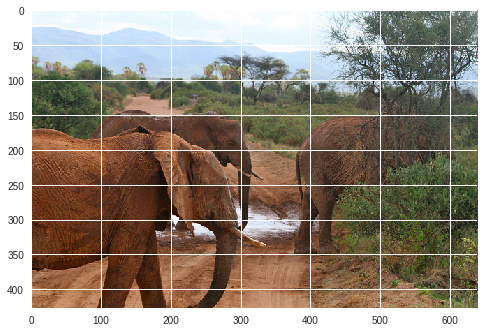

In [0]:
query(gimme_caption(25),gimme_image(25) )

In [0]:
query(gimme_caption(25),gimme_image(25))

caption: <start> a pile of smart phones and electronics laying on the ground <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
caption: <start> a living area with a sofa christmas tree and fireplace <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
caption: <start> a man standing with his thumbs in his pockets in front of a door <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
caption: <start> a steak sandwich with a cup of green sauce on a white plate <end> <pad> <pad> <pad> <pad> <pad> <p

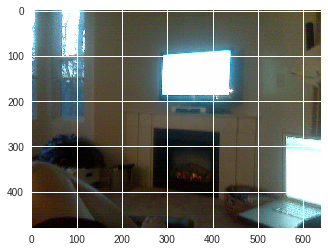

In [0]:
a = []
for i in range(0, 100):
  a.append(query(gimme_caption(i),gimme_image(99)))

In [0]:
np.argmin(a)

52

In [0]:
del a[np.argmin(a)]
np.argmin(a)

96

In [0]:
np.argmax(a)

67

In [0]:
a[38]

0.003417162290481182

In [0]:
a[0]

0.004316225937063545

In [0]:
max(a)

**  RETRIEVE THE TOP 5 IMAGES GIVEN A CAPTION**

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

def show_top_images_with_scores(combined):
#   fig = plt.figure()
  fig, ax = plt.subplots(len(combined),1, figsize=(15, 15))
  i=0
  for score,img_path in combined:
    print("-"*100)
    print("IMAGE IS ...",img_path)
    img = Image.open(img_path)
    
    ax[i].imshow(img)
    print("SCORE IS ....")
    print(score)
    i+=1



In [0]:
#caching the test dataset ka image embeddings
all_test_images = img_name_test
all_test_image_features = list(map(lambda img_name:np.load(img_name +'.npy'), all_test_images))
imgs_embs = test_model_im.predict(np.array(all_test_image_features))

In [0]:
'''
1. prepare caption by making it an embedding
2. take the test dataset ka images which has been pased thru the cnn stack and make 2 lists of -1.with all the features -2.with all the corresponding image_names
3. take the test_models and predict for this caption and all images and get a list of similarity scores.
4. zip the list with the similarity scores and the images_names and sort based on the score using "key"
5.pick top k and show as an image
'''
def get_top_k_images(k,caption):
  cap_inp = caption_to_embedding(caption)
  test_model_cap , test_model_im = get_test_models_from_weights()
  #this might fail if so wrap it around a np.array
#   print(cap_inp.shape)
#   print(cap_inp)
#   return 
  cap_emb = test_model_cap.predict(np.array([cap_inp]))
  print("cap_emb is ",cap_emb.shape)
  #refer the above cell
#   all_test_images = img_name_val
#   all_test_image_features = list(map(lambda img_name:np.load(img_name +'.npy'), all_test_images))
#   imgs_embs = test_model_im.predict(np.array(all_test_image_features))


  print("imgs_embs are",imgs_embs.shape)
  similarity_scores = []
  for img_emb in imgs_embs:
    score=order_violations(cap_emb,img_emb)
    similarity_scores.append(score)
  combined = list(zip(similarity_scores,all_test_images))
  topk= sorted(combined, key=lambda x: x[0])[:k]
  print(topk)
  show_top_images_with_scores(topk)
  return 

caption: <start> a train that is on display under an <unk> <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

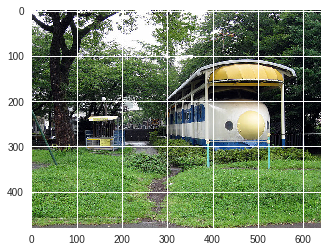

In [0]:

gimme_caption(14)
gimme_image(14)

cap_emb is  (1, 1024)
imgs_embs are (5000, 1024)
[(0.004125533414745475, '/content/train2014/COCO_train2014_000000318995.jpg'), (0.004146891055861135, '/content/train2014/COCO_train2014_000000514558.jpg'), (0.004174139779338726, '/content/train2014/COCO_train2014_000000196093.jpg'), (0.004295388183060744, '/content/train2014/COCO_train2014_000000418087.jpg'), (0.004346487065313376, '/content/train2014/COCO_train2014_000000491467.jpg'), (0.0043990245912672865, '/content/train2014/COCO_train2014_000000035589.jpg')]
----------------------------------------------------------------------------------------------------
IMAGE IS ... /content/train2014/COCO_train2014_000000318995.jpg
SCORE IS ....
0.004125533414745475
----------------------------------------------------------------------------------------------------
IMAGE IS ... /content/train2014/COCO_train2014_000000514558.jpg
SCORE IS ....
0.004146891055861135
---------------------------------------------------------------------------------

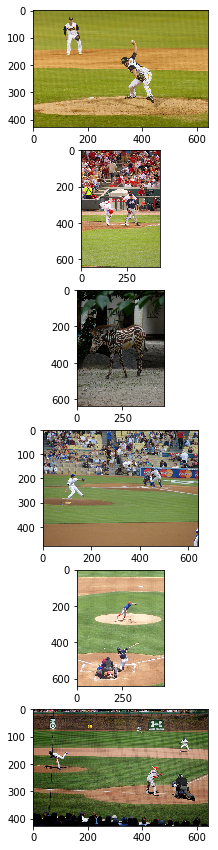

In [0]:
caption = "people playing baseball"
get_top_k_images(6,caption)

cap_emb is  (1, 1024)
imgs_embs are (5000, 1024)
[(0.0043625681168733, '/content/train2014/COCO_train2014_000000398622.jpg'), (0.0043625681168733, '/content/train2014/COCO_train2014_000000398622.jpg'), (0.0044550330184356945, '/content/train2014/COCO_train2014_000000018496.jpg'), (0.004502321463331127, '/content/train2014/COCO_train2014_000000445276.jpg'), (0.004542589397472929, '/content/train2014/COCO_train2014_000000150115.jpg'), (0.0045445721402881945, '/content/train2014/COCO_train2014_000000563342.jpg')]
----------------------------------------------------------------------------------------------------
IMAGE IS ... /content/train2014/COCO_train2014_000000398622.jpg
SCORE IS ....
0.0043625681168733
----------------------------------------------------------------------------------------------------
IMAGE IS ... /content/train2014/COCO_train2014_000000398622.jpg
SCORE IS ....
0.0043625681168733
----------------------------------------------------------------------------------------

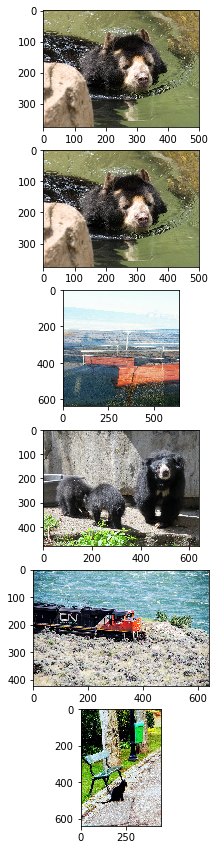

In [0]:
caption = "boats floating in the river"
get_top_k_images(6,caption)

cap_emb is  (1, 1024)
imgs_embs are (5000, 1024)
[(0.002932188633625543, '/content/train2014/COCO_train2014_000000213242.jpg'), (0.003009404968450591, '/content/train2014/COCO_train2014_000000253480.jpg'), (0.003075981270268549, '/content/train2014/COCO_train2014_000000166057.jpg'), (0.0030808050310873747, '/content/train2014/COCO_train2014_000000553184.jpg'), (0.0031113370281966035, '/content/train2014/COCO_train2014_000000439053.jpg'), (0.003142323616327991, '/content/train2014/COCO_train2014_000000548893.jpg')]
----------------------------------------------------------------------------------------------------
IMAGE IS ... /content/train2014/COCO_train2014_000000213242.jpg
SCORE IS ....
0.002932188633625543
----------------------------------------------------------------------------------------------------
IMAGE IS ... /content/train2014/COCO_train2014_000000253480.jpg
SCORE IS ....
0.003009404968450591
--------------------------------------------------------------------------------

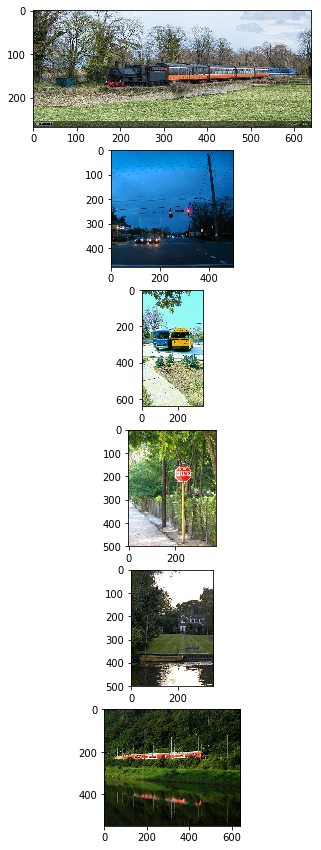

In [0]:
caption = "cats and dogs walking in the park"
get_top_k_images(6,caption)

cap_emb is  (1, 1024)
imgs_embs are (5000, 1024)
[(0.003176999586049556, '/content/train2014/COCO_train2014_000000213305.jpg'), (0.0032350671059844793, '/content/train2014/COCO_train2014_000000146076.jpg'), (0.003243448371465632, '/content/train2014/COCO_train2014_000000550617.jpg'), (0.0032534611308877026, '/content/train2014/COCO_train2014_000000225282.jpg'), (0.0032580180276642473, '/content/train2014/COCO_train2014_000000146313.jpg'), (0.0033076353093406397, '/content/train2014/COCO_train2014_000000080165.jpg')]
----------------------------------------------------------------------------------------------------
IMAGE IS ... /content/train2014/COCO_train2014_000000213305.jpg
SCORE IS ....
0.003176999586049556
----------------------------------------------------------------------------------------------------
IMAGE IS ... /content/train2014/COCO_train2014_000000146076.jpg
SCORE IS ....
0.0032350671059844793
-----------------------------------------------------------------------------

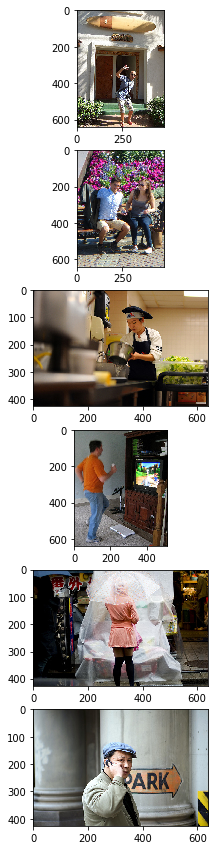

In [0]:
caption = "man riding a bike"
get_top_k_images(6,caption)

In [0]:
len(cap_train) /8

3562.5

In [0]:
0.8 * 30000

24000.0